<a href="https://colab.research.google.com/github/deenukhan/deep_learning/blob/main/2_1_dnn_on_imdb_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Sentiment analysis**

This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem

We'll use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

In [84]:
# This Notebook is inspired the https://www.tensorflow.org/tutorials/keras/text_classification

import os
import re
import string
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [5]:
# # Let's Download the Dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = keras.utils.get_file('aclImdb_v1', url, untar=True, cache_dir='/content/', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [6]:
os.listdir(dataset_dir)

['README', 'imdbEr.txt', 'test', 'imdb.vocab', 'train']

### Load the dataset

In [9]:
# Next, you will load the data off disk and prepare it into a format suitable for training. To do so, 
# you will use the helpful text_dataset_from_directory utility, which expects a directory structure as follows.

# main_directory/
# ...class_a/
# ......a_text_1.txt
# ......a_text_2.txt
# ...class_b/
# ......b_text_1.txt
# ......b_text_2.txt

# First we need to remove unsup folder accoring to our structure that we need

shutil.rmtree(os.path.join(dataset_dir, 'train/unsup'))

In [88]:
batch_size = 32
seed = 54

raw_train_ds = keras.preprocessing.text_dataset_from_directory(
    "/content/aclImdb/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset='training', seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [11]:
type(raw_train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [14]:
type(tf.data.Dataset.from_tensor_slices(tf.constant([1,2,3])))

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [89]:
# Let's Print out the some of the data
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review : ", text_batch.numpy()[i])
        print("Label : ", label_batch.numpy()[i])
    

Review :  b'This had a great cast with big-name stars like Tyrone Power, Henry Fonda, Randolph Scott, Nancy Kelly, Henry Hull and Brian Donlevey and a bunch more lesser-but-known names with shorter roles. It also had Technicolor, one of the few movies made with it in 1939.<br /><br />Now the bad news.......regrettably, I can\'t say much positive for the story. It portrayed the James boys in a totally positive light....and Hollywood has done that ever since. Why these criminals are always shown to be the "good guys" is beyond me. This film glamorizes them and made their enemies - the railroad people - into vicious human beings. The latter was exaggerated so much it was preposterous. Well, that\'s the film world for you: evil is good; good is bad.<br /><br />Hey Hollywood: here\'s a news flash - The James boys were criminals! Really - look it up!'
Label :  0
Review :  b'Finally, after years of awaiting a new film to continue the sexual mayhem of "Basic Instinct", we have been given a gre

In [56]:
# The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, 
# you can check the class_names property on the datase
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [90]:
# Now Let's Create the Validataion dataset

raw_val_ds = keras.preprocessing.text_dataset_from_directory(
    "/content/aclImdb/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset='validation', seed = seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [91]:
# This is our testing dataset
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

In [92]:
# Next, you will standardize, tokenize, and vectorize the data using the helpful preprocessing.TextVectorization layer.

def custom_standardization(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    final_text = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
    return final_text 


In [93]:
# Next, you will create a TextVectorization layer. you will use this layer to standardize, tokenize, 
# and vectorize our data. You set the output_mode to int to create unique integer indices for each token.

max_features = 10000
sequence_length = 250
vectorize_layer = keras.layers.experimental.preprocessing.TextVectorization(
        standardize = custom_standardization,
        max_tokens = max_features,
        output_mode = 'int',
        output_sequence_length = sequence_length
)


In [94]:
# Next, you will call adapt to fit the state of the preprocessing layer to the dataset. 
# This will cause the model to build an index of strings to integers.
# Note: it's important to only use your training data when calling adapt (using the test set would leak information).

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

In [95]:
# Let's create a function to see the result of using this layer to preprocess some data.
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [96]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Picture the scene where a bunch of scriptwriters sit around a table and one says "lets have a black woman approach an unsuspecting member of the public (also black) in the street and ask him if he is black, then walk away". The other writers fall about laughing hysterically until one suggests they repeat it in every episode. More laughter. Now if you think the premise is funny, and the show contains many such types of situation, you will enjoy this show. For the rest, use your zapper and find something more entertaining like watching paint dry. Those that have written glowing reports of this show should either get out more or be forced to watch television comedies that are really funny. Another example of the humor in the show, a girl tries to get out of paying at a supermarket checkout by trying to hypnotise the cashier. Marginally funny the first time but why repeat it over and over in different shows with different cashiers? I could give other examples but these j

In [97]:
# As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print("313 ---> ", vectorize_layer.get_vocabulary()[313])
print("Size of the Vocabulary ", len(vectorize_layer.get_vocabulary()))

1287 --->  places
313 --->  idea
Size of the Vocabulary  10000


In [98]:
# You are nearly ready to train your model. As a final preprocessing step, you will apply the 
# TextVectorization layer you created earlier to the train, validation, and test dataset.

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_train_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

In [99]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

### Create the model

In [100]:
embedding_dim = 16

model = keras.models.Sequential([
        keras.layers.Embedding(max_features + 1, embedding_dim),
        keras.layers.Dropout(0.2),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Loss function, optimizer and Training

In [101]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [102]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs = epochs)

Epoch 1/10
625/625 [==============================] - 12s 18ms/step - loss: 0.6827 - binary_accuracy: 0.6292 - val_loss: 0.6164 - val_binary_accuracy: 0.7480
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5811 - binary_accuracy: 0.7844 - val_loss: 0.5018 - val_binary_accuracy: 0.8094
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4657 - binary_accuracy: 0.8337 - val_loss: 0.4243 - val_binary_accuracy: 0.8378
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3918 - binary_accuracy: 0.8603 - val_loss: 0.3787 - val_binary_accuracy: 0.8568
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3444 - binary_accuracy: 0.8728 - val_loss: 0.3506 - val_binary_accuracy: 0.8624
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3119 - binary_accuracy: 0.8851 - val_loss: 0.3322 - val_binary_accuracy: 0.8670
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

In [103]:
# Evaluating the Model
model.evaluate(test_ds)

625/625 [==============================] - 8s 12ms/step - loss: 0.2154 - binary_accuracy: 0.9201


[0.21543234586715698, 0.9200999736785889]

### Create a plot of accuracy and loss over time

In [104]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

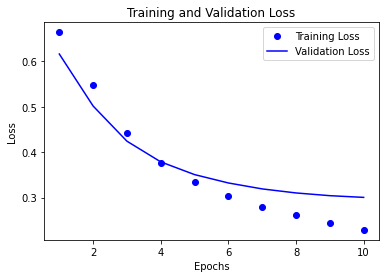

In [105]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.show()

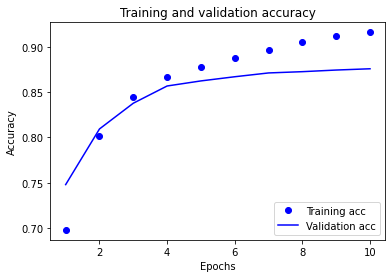

In [106]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Export the model

In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [107]:
export_model = keras.models.Sequential([
                vectorize_layer,
                model,
                keras.layers.Activation('sigmoid')
])

export_model.compile( loss = keras.losses.BinaryCrossentropy(from_logits=False),
                     metrics = ['accuracy'], optimizer = 'adam')

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy, loss)

782/782 [==============================] - 11s 14ms/step - loss: 0.3071 - accuracy: 0.8753
0.8695200085639954 0.3131662607192993


### Inference on new data

In [108]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.7364978 ],
       [0.57069397],
       [0.48971915]], dtype=float32)